# Reproduct Autopilot Architecture

The Autopilot has the following Architecture:
~ ResNet50-like backbone
~ FPN - DeepLabV3- UNet - like heads
~ 15 tasks
    ~ subtasks i.e. if task is car detection, then the sub task is what kind of car, is it stationary? Parked, broken down?

For later exploration:
Stitching up of images across space and time happens inside RNNs.
Also explore Faster R-CNNs but they have lower inference rate in real-time detection etc.


## First Step:
Use transfer learning to load ResNet-50 model because training it and loading it that way has been a hassle.

We are most likely using feature extraction techniques to get the data from resnet backbone and passing them onto the tasks

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import models, transforms
import matplotlib.pyplot as plt
import numpy as np


from timeit import default_timer as timer

In [2]:
batch_size = 50

# get the CIFAR-10 images:

train_data_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4821, 0.4465), (0.2470, 0.2435, 0.2616))
])

train_set = torchvision.datasets.CIFAR10(root='./data',
                                        train=True, download = True,
                                        transform=train_data_transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                           shuffle=True, num_workers=2)


Files already downloaded and verified


In [3]:
train_loader.dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train

## CIFAR10 Data
10000 x 3072 numpy arrays. i.e 1024 values i.e. 32x32 image and since there are 3 channels, we get 3072 shaped numpy arrays.
Each row in the array stores a 32x32 colour image
The first 1024 entries contain the red channel values, the next 1024 are green and the next 1024 are blue.


In [4]:
def imshow(img):
    img = img/2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()
    

In [5]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

In [6]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


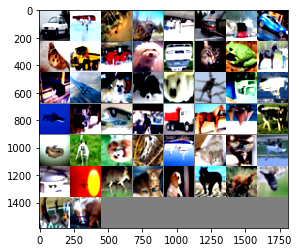

  car  ship  frog  bird truck truck  ship   car   dog truck truck   dog   car   cat  frog horse   cat plane   dog   dog   dog  bird truck  ship plane truck   car horse truck horse  ship   dog  frog   cat   dog  frog  ship   dog   cat plane  ship plane  deer   cat   dog horse  deer  bird horse horse


In [7]:
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s'%classes[labels[j]] for j in range(50)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


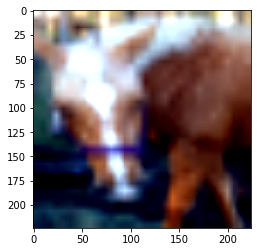

In [8]:
imshow(images[49])

In [9]:
len(train_loader)

1000

In [10]:
val_data_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4821, 0.4465), (0.2470, 0.2435, 0.2616))
])
val_set = torchvision.datasets.CIFAR10(root='./data',
                                      train=False, download=True,
                                      transform=val_data_transform)
val_order = torch.utils.data.DataLoader(val_set,
                                        
                                        batch_size=batch_size,
                                        shuffle=False, num_workers=2
                                       )

Files already downloaded and verified


In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [12]:
def train_model(model, loss_function, optimizer, data_loader):
    # set the model mode
    model.train()
# iterate over the examples in the dataset:
    current_loss = 0
    current_acc = 0
    
    for i, (inputs, labels) in enumerate(data_loader):
    # send them to the GPU first
        inputs = inputs.to(device)
        labels = labels.to(device)

    # zero the parameter gradients
        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
        # forward
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)
            loss = loss_function(outputs, labels)

        # backward
            loss.backward()
            optimizer.step()

        # statistics
        current_loss += loss.item() * inputs.size(0)
        current_acc += torch.sum(predictions == labels.data)

    total_loss = current_loss / len(data_loader.dataset)
    total_acc = current_acc.double() / len(data_loader.dataset)

    print('Train Loss: {:.4f}; Accuracy {:.4f}'.format(total_loss, total_acc))
#    print(f'Epochs: {epochs}\t{100 * (i + 1) / len(data_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.', end='\r')
    return total_loss, total_acc

In [13]:
def test_model(model, loss_function, data_loader):
    # set model in evaluation mode
    model.eval()
    
    current_loss = 0.0
    current_acc = 0
    valid_loss_min = np.Inf
    epochs_no_improve=0
    valid_max_acc = 0
    history=[]
    # iterate over the validation data
    for i, (inputs, labels) in enumerate(data_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)
            loss = loss_function(outputs, labels)
            
        # statistics
        current_loss += loss.item() * inputs.size(0)
        current_acc += torch.sum(predictions == labels.data)
        
    total_loss = current_loss / len(data_loader.dataset)
    total_acc = current_acc.double()/ len(data_loader.dataset)
    history.append([current_loss, total_loss, current_acc, total_acc])
    
    # print the results:
    return total_loss, total_acc
    
    

Now, onto the transfer learning scenario where we are going to use the pretrained network as a feature extractor.
1. Let's use ResNet50
2. Replace last layer of the model with a new layer with 10 outputs
3. Exclude the existing network layers from the backward pass and only pass the newly added fully-connected layer to the Adam optimizer.
4. Run the training for epochs and evaluate the network accuracy after each epoch.
5. Plot the test accuracy

# Load Resnet50

In [14]:
model = torchvision.models.resnet50(pretrained=True)
# model.eval()

In [15]:
def plot_accuracy(accuracy: list):
    """Plot accuracy"""
    plt.figure()
    plt.plot(accuracy)
    plt.xticks(
        [i for i in range(0, len(accuracy))],
        [i + 1 for i in range(0, len(accuracy))])
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.show()

In [16]:
def tl_feature_extractor(epochs=5):
    # load the pretrained model
    model = torchvision.models.resnet50(pretrained=True)
    
    # exclude the existing parameters from backward pass
    # for performance
    for param in model.parameters():
        param.requires_grad = False
        
    # newly constructed layers have requires_grad=True by default
    num_features = model.fc.in_features
    model.fc = nn.Sequential(
                nn.Linear(num_features, 1000),
                nn.ReLU(),
                nn.Dropout(0.4),
                nn.Linear(1000, 10),
                nn.LogSoftmax(dim=1))
#    model.fc = nn.Linear(1000, 10)
    
    # transfer to GPU
    model = model.to(device)
    
    loss_function = nn.CrossEntropyLoss()
    
    # only parameters of the final layer are being optimized
    optimizer = optim.Adam(model.fc.parameters())    # otherwise, it would be just model.parameters()
    
    # how many epochs have been trained:
    epochs_no_improve = 0
    valid_loss_min = np.Inf
    
    valid_max_acc = 0
    history = []
    
    # no. of epochs already being trained (if using loaded_in model weeights)
    try: 
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting training from scratch.\n')
        
    # setting timing
    overall_start = timer()
    # train
    test_acc = list()
    for epoch in range(epochs):
        start = timer()
        print('Epoch {}/{}'.format(epoch+1, epochs))
#        print(f'Epochs: {epoch}\t{100 * (i + 1) / len(data_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.', end='\r')

        
        total_loss, total_acc = train_model(model, loss_function, optimizer, train_loader)
        loss, acc = test_model(model, loss_function, val_order)
        test_acc.append(acc)
        total_time = timer() - overall_start

        if (epoch + 1) % print_every == 0:
            print(f'\nEpoch: {epoch} \tTraining Loss: {total_loss:.4f} \tValidation Loss: {valid_loss:.4f}')
            print('Test Loss: {:.4f}; Accuracy {:.4f}'.format(loss, acc))
            print(f'{Total_time:.2f} total seconds elapsed. {total_time/(epoch):.2f} seconds per epoch.')
            
    plot_accuracy(test_acc)

In [17]:
def train(model,
          loss_function, 
          optimizer,
          train_loader,
          val_loader,
          save_file_name,
          max_epochs_stop=3,
          n_epochs=20,
          print_every=2):

    # initiate early stopping:
    # some pre-defined parameters:
    epochs_fit = 0
    min_val_loss = np.Inf
    max_val_acc = 0
    history = []

    # print statements:
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training.\n')

    overall_start = timer()
    
    # Main Loop
    # different from the regular where we define train and test functions separately based on model we want to train
    for epoch in range(n_epochs):
        # initiate current accuracy and loss
        train_acc = 0
        train_loss = 0
        # set the eval mode
        model.train()
        start = timer()

        for i, (inputs, labels) in enumerate(train_loader):
            # define the device first i.e. if GPU go to gpu else CPU
            inputs = inputs.to(device)
            labels = labels.to(device)

        # zero the gradients:
            optimizer.zero_grad()

            with torch.set_grad_enabled(True):
                # forward i.e. predicted outputs are log probabilities
                outputs = model(inputs)
                # find accuracy by finding max log probability
                _, predictions = torch.max(outputs, 1)
                # .eq computes elementwise equality
                # so we get this 
                correct_tensor = predictions.eq(labels.inputs.view_as(predictions))
                accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
                
                loss = loss_function(outputs, labels)

            # backward
                loss.backward()
                optimizer.step()

            # Statistics
            train_loss += loss.item() * inputs.size(0)
            train_acc += accuracy.item() * inputs.size(0)
            train_acc += torch.sum(predictions == labels.data)

        total_loss = train_loss/len(train_loader.dataset) # dataset returns an object with dataset details
        total_acc = train_acc.double() / len(train_loader.dataset) # length is the total number of examples in the data_loader object

        print(f'Epoch: {epoch}\t{100 * (i + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.', end='\r')
        print('Train Loss: {:.4f}; Accuracy {:.4f}'.format(total_loss, total_acc))

        else:
            model.epochs += 1

            with torch.no_grad():
                # set the model in evaluation mode
                model.eval()

                valid_loss = 0.0
                valid_acc = 0

                for inputs, labels in val_loader:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    with torch.set_grad_enabled(False):
                        outputs = model(inputs)
                        _, predictions = torch.max(outputs, 1)
                        loss = loss_function(outputs, labels)

                    valid_loss += loss.item() * inputs.size(0)
                    valid_acc += torch.sum(predictions == labels.data)

                total_val_loss = valid_loss / len(val_loader.dataset)
                total_val_acc = valid_acc.double()/ len(val_loader.dataset)

                history.append([train_loss, valid_loss, train_acc, valid_acc])

                if (epoch + 1) % print_every == 0:
                    print(f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f}\tValidation Loss: {valid_loss:.4f}')
                    print(f'\t\Training Accuracy: {100 * train_acc:.2f}%\t validation Accuracy: {100 * valid_acc:.2f}%')
                    print('Test Loss: {:.4f}; Accuracy{:.4f}'.format(total_val_loss, total_val_acc))

            # when to save the model:

                if valid_loss < min_val_loss:

                    torch.save(model.state_dict(), save_file_name)

                    epochs_fit = 0
                    min_val_loss = valid_loss
                    max_val_acc = valid_acc
                    best_epoch = epoch

                else:
                    epochs_fit += 1
                    if epochs_fit >= max_epochs_stop:
                        print(
                        f'\nEarly Stopping! Total Epochs: {epoch}. Best epoch: {best_epoch} with loss: {min_val_loss:.2f} and acc:{100 * valid_acc:.2f}%')
                        total_time = timer() - overall_start
                        print(f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.')

                        model.load_state_dict(torch.load(save_file_name))
                        # attach the optimizer
                        model.optimizer = optimizer

                        history = pd.DataFrame(history, columns = ['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])

                        return model, history
                    
    model.optimizer = optimizer
    total_time = timer() - overall_start
    print(f'\nBest Epoch: {best_epoch} with loss: {min_val_loss:.2f} and acc: {100 * valid_acc:.2f}%')
    print(f'{total_time:.2f} total seconds elapsed. {total_time/ (epoch):.2f})
                    


In [18]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [19]:
model = models.resnet50(pretrained=True)
n_inputs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2),
    nn.Linear(256, 10), nn.LogSoftmax(dim=1))


In [20]:
# model.eval()

In [21]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters())


In [ ]:
model, history = train(
    model,
    loss_function,
    optimizer,
    train_loader,
    val_order,
    save_file_name = 'resnetmodel',
    max_epochs_stop=5,
    n_epochs=5,
    print_every=2)

Starting Training.



# Inference

In [2]:
model = torchvision.models.squeezenet1_1(pretrained=True)
model.eval()

Downloading: "https://download.pytorch.org/models/squeezenet1_1-f364aa15.pth" to C:\Users\Billi/.cache\torch\checkpoints\squeezenet1_1-f364aa15.pth
100%|████████████████████████████████████████| 4966400/4966400 [00:01<00:00, 2784771.41it/s]


SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace)
    )
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0

In [3]:
model = torchvision.models.resnet50(pretrained=True)
model.eval()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to C:\Users\Billi/.cache\torch\checkpoints\resnet50-19c8e357.pth
100%|███████████████████████████████████| 102502400/102502400 [00:04<00:00, 21845405.26it/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [29]:
arr = np.array([[1, 2, 3, 10], [5, 3, 56, 2], [50, 123, 12, 20], [2, 123, 43, 99], [23, 2, 3, 2]])

In [30]:
H, W = arr.shape[-2:]

In [31]:
H

5

In [32]:
W

4

# Adding FPN head